
# Exporting DeePTB Models to External Tools (PythTB)

DeePTB not only provides its own powerful training and analysis tools but also allows you to export your trained tight-binding models to popular external formats. This opens up compatibility with a vast ecosystem of post-processing tools.

In this tutorial, we will demonstrate:
1.  **DeePTB Native Analysis**: Calculating band structure using DeePTB's built-in tools.
2.  **Safety Check**: Verifying that the model is compatible with external tools (no overlap).
3.  **Export**: Converting the DeePTB model to a **PythTB** model object.
4.  **PythTB Analysis**: Calculating band structure with PythTB and comparing.

## Prerequisites
- `dptb`
- `pythtb`
- `ase`
- `matplotlib`

In [203]:
import os
import torch
from dptb.nn import build_model
from dptb.data import AtomicData
from ase.io import read
from dptb.postprocess.interfaces import ToWannier90, ToPythTB
import matplotlib.pyplot as plt
import numpy as np
from dptb.postprocess.bandstructure.band import Band


## 1. Load Pre-trained Model

In [ ]:

# Define paths to example data
root_dir = os.path.abspath(".") 
model_path = os.path.join(root_dir, "models", "nnsk.ep20.pth")
struct_path = os.path.join(root_dir, "silicon.vasp")

print(f"Loading model from {model_path}...")
model = build_model(model_path)
model.eval()
print("Model loaded.")


The model option atomic_radius in nnsk is not defined in input model_options, set to v1.


Loading model from /Users/aisiqg/Desktop/work/github/DeePTB/examples/ToPythTB/models/nnsk.ep20.pth...
Model loaded.



## 2. DeePTB Native Band Structure

First, we calculate the band structure using DeePTB's `Band` class. This serves as our reference.


eig_solver is not set, using default 'torch'.


Plotting DeePTB Band Structure...


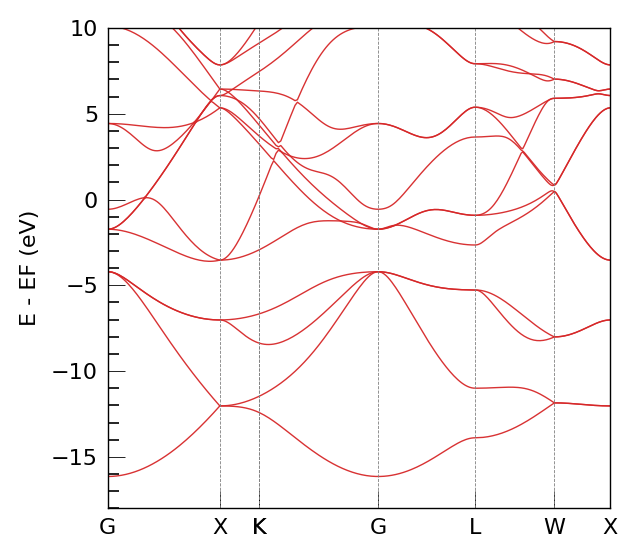

In [273]:

# Configuration for Band Calculation
jdata={   
    "task_options": {
        "task": "band",
        "kline_type":"abacus",
        "kpath":[[0.0000000000,  0.0000000000,   0.0000000000,   50],   
                [0.5000000000,   0.0000000000,   0.5000000000,   50],               
                [0.6250000000,   0.2500000000,   0.6250000000,   1],    
                [0.3750000000,   0.3750000000,   0.7500000000,   50],     
                [0.0000000000,   0.0000000000,   0.0000000000,   50],    
                [0.5000000000,   0.5000000000,   0.5000000000,   50],                
                [0.5000000000,   0.2500000000,   0.7500000000,   50],               
                [0.5000000000,   0.0000000000,   0.5000000000,   1 ]
                ],
        "klabels":["G","X","X/U","K","G","L","W","X"],
        "nel_atom":{"Si":4},
        "E_fermi":-4.722,
        "emin":-18,
        "emax":10,
        "ref_band": None 
    }
}
kpath_kwargs = jdata["task_options"]

# Calculate Bands
bcal = Band(model=model, use_gui=False, device=model.device) # use_gui=False for notebook
eigens = bcal.get_bands(data=struct_path, kpath_kwargs=kpath_kwargs)

# Plot DeePTB Bands
print("Plotting DeePTB Band Structure...")
bcal.band_plot(ref_band = None,
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])



## 3. Export to PythTB and Verification

Now we export the valid orthogonal model to PythTB and verify that the band structure matches.


In [274]:

# Initialize Exporter
exporter = ToPythTB(model)

# Export to PythTB model object
print("Exporting to PythTB...")
tb_model = exporter.get_model(struct_path)
print("Successfully exported!")
print(tb_model)


Exporting to PythTB...
Successfully exported!



### Calculate and Plot PythTB Bands

We use PythTB's native methods to calculate the bands along the same k-path (approximate mapping) to verify consistency.


----- k_path report begin ----------
real-space lattice vectors
 [[0.    2.715 2.715]
 [2.715 0.    2.715]
 [2.715 2.715 0.   ]]
k-space metric tensor
 [[ 0.10175 -0.03392 -0.03392]
 [-0.03392  0.10175 -0.03392]
 [-0.03392 -0.03392  0.10175]]
internal coordinates of nodes
 [[0.   0.   0.  ]
 [0.   0.5  0.5 ]
 [0.25 0.5  0.75]
 [0.   0.   0.  ]
 [0.5  0.5  0.5 ]]
reciprocal-space lattice vectors
 [[-0.18416  0.18416  0.18416]
 [ 0.18416 -0.18416  0.18416]
 [ 0.18416  0.18416 -0.18416]]
cartesian coordinates of nodes
 [[0.00000e+00 0.00000e+00 0.00000e+00]
 [1.84162e-01 0.00000e+00 0.00000e+00]
 [1.84162e-01 9.20810e-02 6.93889e-18]
 [0.00000e+00 0.00000e+00 0.00000e+00]
 [9.20810e-02 9.20810e-02 9.20810e-02]]
list of segments:
  length = 0.18416  from  [0. 0. 0.]  to  [0.  0.5 0.5]
  length = 0.09208  from  [0.  0.5 0.5]  to  [0.25 0.5  0.75]
  length =  0.2059  from  [0.25 0.5  0.75]  to  [0. 0. 0.]
  length = 0.15949  from  [0. 0. 0.]  to  [0.5 0.5 0.5]
node distance list: [0.      0.

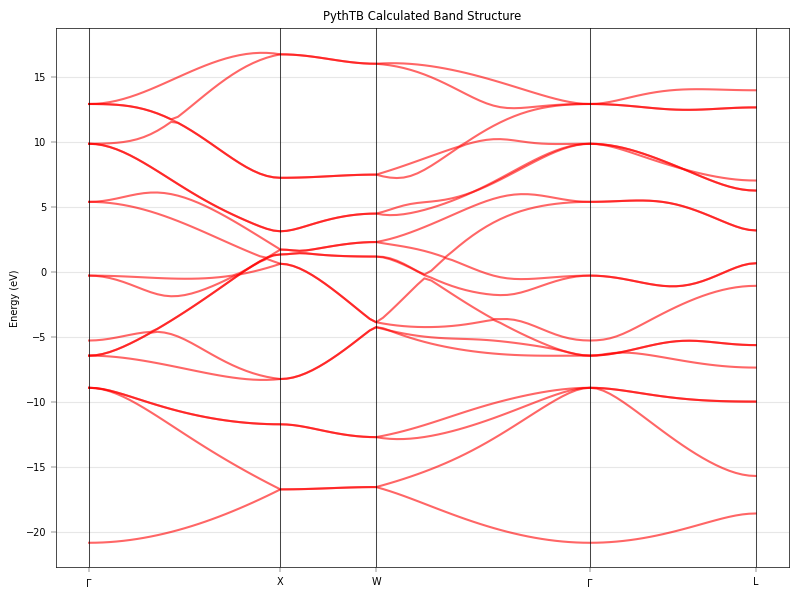

In [275]:

# Define K-path in PythTB format (Si High Symmetry Points)
# Gamma=(0,0,0), X=(0,0.5,0.5), L=(0.5,0.5,0.5), W=(0.25, 0.5, 0.75), K=(0.375, 0.375, 0.75)
# Note: DeePTB and PythTB might define paths slightly differently, but critical points match.

k_path_nodes = [
    [0.0, 0.0, 0.0], # Gamma
    [0.0, 0.5, 0.5], # X
    [0.25, 0.5, 0.75], # W
    [0.0, 0.0, 0.0], # Gamma
    [0.5, 0.5, 0.5], # L
]
k_path_labels = [r'$\Gamma$', 'X', 'W', r'$\Gamma$', 'L']

# Create k-path
(k_vec, k_dist, k_node) = tb_model.k_path(k_path_nodes, 100)

# Solve for eigenvalues
print("Solving with PythTB...")
evals = tb_model.solve_all(k_vec)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
# PythTB returns shape (num_orbitals, num_kpoints)
for i in range(evals.shape[0]):
    ax.plot(k_dist, evals[i,:], 'r-', lw=1.5, alpha=0.6, label='PythTB' if i==0 else "")

# Decorate
for n in k_node:
    ax.axvline(n, color='k', lw=0.5)
ax.set_xticks(k_node)
ax.set_xticklabels(k_path_labels)
ax.set_ylabel("Energy (eV)")
ax.set_title("PythTB Calculated Band Structure")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


eig_solver is not set, using default 'torch'.


Plotting DeePTB Band Structure...


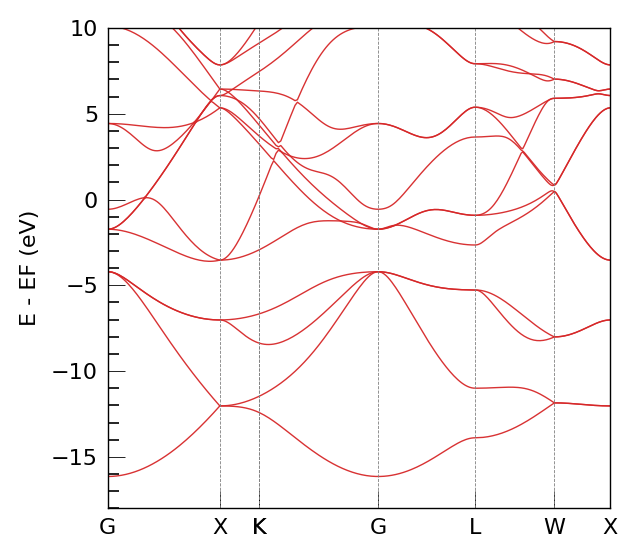

In [269]:

# Configuration for Band Calculation
jdata={   
    "task_options": {
        "task": "band",
        "kline_type":"abacus",
        "kpath":[[0.0000000000,  0.0000000000,   0.0000000000,   50],   
                [0.5000000000,   0.0000000000,   0.5000000000,   50],               
                [0.6250000000,   0.2500000000,   0.6250000000,   1],    
                [0.3750000000,   0.3750000000,   0.7500000000,   50],     
                [0.0000000000,   0.0000000000,   0.0000000000,   50],    
                [0.5000000000,   0.5000000000,   0.5000000000,   50],                
                [0.5000000000,   0.2500000000,   0.7500000000,   50],               
                [0.5000000000,   0.0000000000,   0.5000000000,   1 ]
                ],
        "klabels":["G","X","X/U","K","G","L","W","X"],
        "nel_atom":{"Si":4},
        "E_fermi":-4.722,
        "emin":-18,
        "emax":10,
        "ref_band": None 
    }
}
kpath_kwargs = jdata["task_options"]

# Calculate Bands
bcal = Band(model=model, use_gui=False, device=model.device) # use_gui=False for notebook
eigens = bcal.get_bands(data=struct_path, kpath_kwargs=kpath_kwargs)

# Plot DeePTB Bands
print("Plotting DeePTB Band Structure...")
bcal.band_plot(ref_band = None,
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])


## PythTB计算能带，使用DeePTB内置的 k点 

In [276]:
evals = tb_model.solve_all(eigens['klist'])

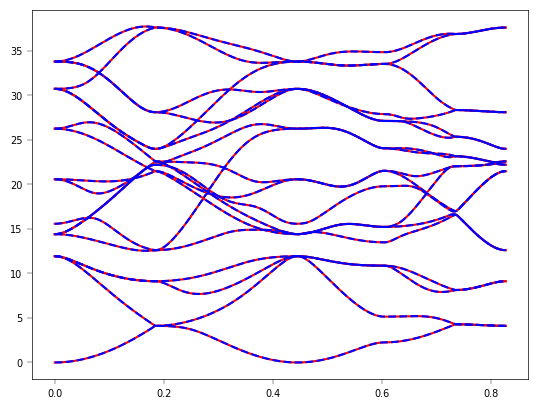

In [277]:
refeig = evals[:,:].T
plt.plot(eigens['xlist'],refeig - refeig.min() ,'r')
plt.plot(eigens['xlist'],eigens['eigenvalues']-eigens['eigenvalues'].min(),'b--')
plt.show()


**现在DeePTB完成了与 PythTB 的对接，你可以基于PythTB进行一些性质计算**

要深入了解 PythTB 的使用，请参考其官方文档，其中包含详细的安装指南、API 参考和教程：[官方文档](https://www.physics.rutgers.edu/pythtb/)